# Parametric forward fitting

In addition to parametric mass models, which can be well-motivated from a physical point of view but make strong assumptions on the shape of the mass profile, _hydromass_ also implements the so-called _forward_ approach, in which the 3D pressure profile is described by a parametric functional form $P(r|\theta)$. The pressure gradient can then be computed analytically from the model pressure, such that the hydrostatic mass profile and its posterior error envelope can be computed point-by-point as

$$ M(<r) = - \frac{r^2}{G\rho_{gas}(r)}\frac{d P(r|\theta)}{d r} . $$

_hydromass_ provides two different ways of defining the model pressure profile. In the "classical" forward-fitting approach, the model pressure is described as a generalized Navarro-Frenk-White (gNFW) approach (e.g. [Arnaud et al. 2010](https://ui.adsabs.harvard.edu/abs/2010A%26A...517A..92A/abstract)). Alternatively, the model can be defined according to a polytropic stratification relation, with the effective polytropic index $\Gamma$ being radially dependent.

The parametric gNFW function is flexible enough to provide a good empirical description of the observed pressure profiles, thus it is a good way of checking how mass models reproduce the data at hand. Conversely, the polytropic model provides a physically motivated description of the pressure profile that can be useful with low-quality data for which the temperature and/or SZ information is scarce.

While the approximation of a constant polytropic index is reasonably accurate in cluster outskirts, $\Gamma$ is known to vary significantly within cluster cores. _hydromass_ provides radially-dependent polytropic models ([Ghirardini et al. 2019a](https://ui.adsabs.harvard.edu/abs/2019A%26A...627A..19G/abstract)) which were found to provide a good representation of galaxy cluster data. Generally speaking, the polytropic model is a good alternative in the case of relatively low-quality data.

In [1]:
import numpy as np

import pyproffit

import hydromass

import matplotlib.pyplot as plt


We start by reloading the data of the test cluster MACS 0451...

In [2]:
datv, p2 = pyproffit.Reload('../../test_data/sb_pyproffit.fits')

DATA structure found
Corresponding pixels coordinates:  428.00000000000836 416.0000000000049
PSF structure found


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 53265.507373 from DATE-END'. [astropy.wcs.wcs]


And we load the spectroscopic temperature data...

In [3]:
z_m0451 = 0.5398 # Source redshift
nh_m0451 = 0.0454 # Galactic NH

rsp = '/Users/deckert/Documents/Work/devel/hydromass/test_data/m1.rsp' # on-axis response file

spec_data = hydromass.SpecData(redshift=z_m0451,
                               spec_data='../../test_data/spectral_results_MACS0451.fits')

def fking(x):
    r0=0.0883981
    alpha=1.58918
    return np.power(1.+(x/r0)**2,-alpha)

spec_data.PSF(pixsize=2.5/60., psffunc=fking)

Reading spectral data from file ../../test_data/spectral_results_MACS0451.fits


## Parametric forward model ##

Galaxy cluster pressure profiles are known to be relatively universal. They can be well described by a gNFW functional form,  which is a flexible functional form that was found to give a good representation of X-ray and SZ data, 

$$ P(r) = \frac{N_0}{(c_{s} r)^{\gamma}(1+(c_{s}r)^\alpha)^{(\beta-\gamma)/\alpha}} .$$

Note that the gNFW is usually defined relative to the self-similar pressure normalization $P_{500}$ and the scaled radius $x=r/R_{500}$ ([Arnaud et al. 2010](https://ui.adsabs.harvard.edu/abs/2010A%26A...517A..92A/abstract)). Here the mass is _a priori_ not known, thus the normalization $N_0$ corresponds to $P_0 P_{500}$ in the usual definition, and similarly, $c_{s}$ actually corresponds to $c_{500}/R_{500}$ in the [Arnaud et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010A%26A...517A..92A/abstract) definition.



### Model definition and optimization ###

Forward fitting with the gNFW model can be easily performed in _hydromass_ by using the [hydromass.Forward](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.forward.Forward) class. We start by loading an [hydromass.Mhyd](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.mhyd.Mhyd) object, passing the data and computing the conversion between count rate and emissivity, 

In [4]:
mforw = hydromass.Mhyd(sbprofile=p2, 
                        spec_data=spec_data, 
                        redshift=z_m0451)

mforw.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)

No output directory name provided, will output to subdirectory "mhyd" 
No cosmology provided, will default to Planck15
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc
Mean cluster temperature: 8.161195  keV

		XSPEC version: 12.12.0
	Build Date/Time: Fri Jan 14 18:24:26 2022

XSPEC12>cosmo 67.74 0 0.69101
XSPEC12>abund angr
 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)
XSPEC12>model phabs(apec)

Input parameter value, delta, min, bot, top, and max values for ...
              1      0.001(      0.01)          0          0     100000      1e+06
1:phabs:nH>0.0454
              1       0.01(      0.01)      0.008      0.008         64         64
2:apec:kT>8.16119
              1     -0.001(      0.01)          0          0          5          5
3:apec:Abundanc>0.3
              0      -0.01(      0.01)     -0.999     -0.999         10         10
4:apec:Redshift>0.5398
      

Now we can declare the model and set the priors on its parameters. This is done through the [hydromass.Forward](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.forward.Forward) class. The parameter list of the model and the corresponding default priors (based on [Planck Collaboration V, 2013](https://ui.adsabs.harvard.edu/abs/2013A%26A...550A.131P/abstract)) are the following:

- Par 1: $N_0$, $\log N_0 \sim \mathcal{N}(-2, -2)$
- Par 2: $c_{s}$, $c_s\sim \mathcal{N}(1.5/1200, 1.0/1200)$
- Par 3: $\gamma$, $\gamma\sim\mathcal{N}(0.3, 0.5)$
- Par 4: $\alpha$, $\alpha\sim\mathcal{N}(1.3, 0.5)$
- Par 5: $\beta$, $\beta\sim\mathcal{N}(4.4, 2.0)$

The central values and the standard deviations of the priors can be adjusted using the _start_ and _sd_ arguments of the [hydromass.Forward](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.forward.Forward) constructor by passing arrays of values. 

By default, all the parameters of the gNFW model are free to vary while fitting. If instead of optimizing for all parameters we wish to fix one of them to its central value, we can pass an array of booleans to the model using the _fix_ argument, which will set whether any given parameter will be fitted (False) or fixed (True).

In [5]:
modforw = hydromass.Forward(fix=[False, False, False, False, False])


Alternatively, the priors and fit parameters can also be modified a posteriori by accessing the _start_, _sd_, _limits_, and _fix_ attributes of the [hydromass.Forward](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.forward.Forward) class. For instance if we want to change the standard deviation of the prior on $\gamma$ to 1.0,

In [6]:
print(modforw.sd)

modforw.sd[2] = 1.0

[0.01, 0.0008333333333333334, 0.5, 0.5, 2.0]


We are now ready to optimize the model, which is done through the [run_forward](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.mhyd.Mhyd.run_forward) method of the Mhyd class. Similar to the mass model optimization, the method uses PyMC3 to fit all the loaded datasets jointly. At each step, the model pressure profile is combined with the gas density to predict the 3D temperature profile, which is then projected with spectroscopic-like weights and convolved with the PSF mixing matrix to be compared with the 2D spectroscopic temperature data. 

The number of HMC samples and tuning steps as well as a number of parameters describing the multiscale gas density model can be easily set. Here we make a quick test run with 100 samples and 100 tuning steps,

In [7]:
mforw.run_forward(modforw,
                  nmcmc=100, 
                  tune=100)

Single conversion factor provided, we will assume it is constant throughout the radial range
coefs -187.90419872441586
p0_interval__ -0.08490196666224548
c500_interval__ -15.98074019506248


/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


gamma_interval__ -1.4395838542397221
alpha_interval__ -0.9338699254892735
beta_interval__ -1.1138006205343867
Running MCMC...


/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Convergence achieved at 14400
Interrupted at 14,399 [7%]: Average Loss = 3,236
/Users/deckert/opt/anaconda3/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, gamma, c500, p0, coefs]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 27 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.


Done.
 Total computing time is:  0.7884353677431742  minutes


We can view the output chains and the posterior parameter distributions by analyzing the _trace_ attribute of the Mhyd class using the Arviz library,

array([[<AxesSubplot:title={'center':'p0'}>,
        <AxesSubplot:title={'center':'p0'}>],
       [<AxesSubplot:title={'center':'c500'}>,
        <AxesSubplot:title={'center':'c500'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

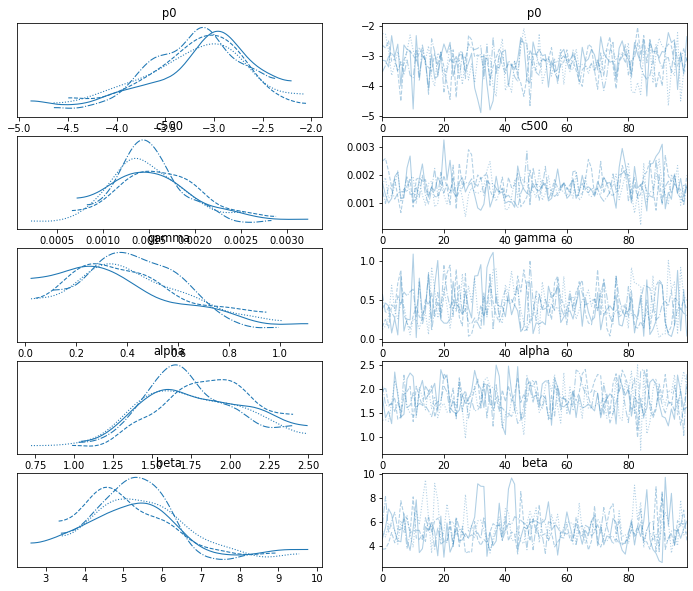

In [8]:
import arviz as az

az.plot_trace(mforw.trace, var_names=modforw.parnames)

Nice posterior distributions and well-converged chains are achieved already with just 100 samples. Obviously, longer chains are required to verify convergence and sample the posterior distributions more accurately.

### Inspecting the results ###

By default, the [run_forward](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.forward.Run_Forward_PyMC3) function computes the model temperature, pressure, and surface brightness profiles are computed on the same binning as the data and loaded as attributes of the Mhyd object. They can be easily viewed in the following way,

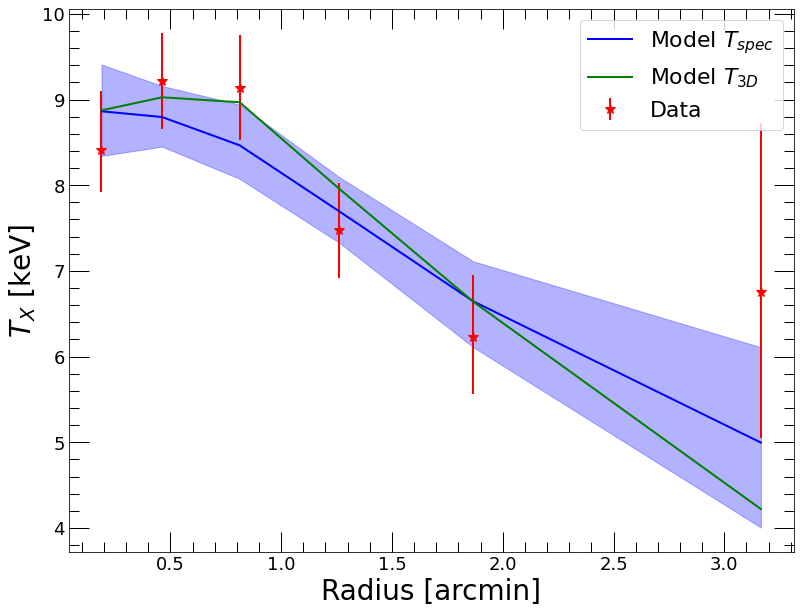

In [9]:
plt.style.use('MyStyle') # custom matplotlib style; set your own, e.g. "ggplot"!

plt.clf()

plt.xlabel('Radius [arcmin]')
plt.ylabel('$T_{X}$ [keV]')
plt.errorbar(spec_data.rref_x_am,spec_data.temp_x,yerr=np.array([spec_data.templ,spec_data.temph]),fmt='*',color='red', label='Data')
plt.plot(spec_data.rref_x_am,mforw.ktmod,color='blue', label='Model $T_{spec}$')
plt.fill_between(spec_data.rref_x_am, mforw.ktmod_lo, mforw.ktmod_hi, color='blue', alpha=0.3)
plt.plot(spec_data.rref_x_am,mforw.kt3d,color='green', label='Model $T_{3D}$')

plt.legend(fontsize=22)

<Figure size 936x720 with 0 Axes>

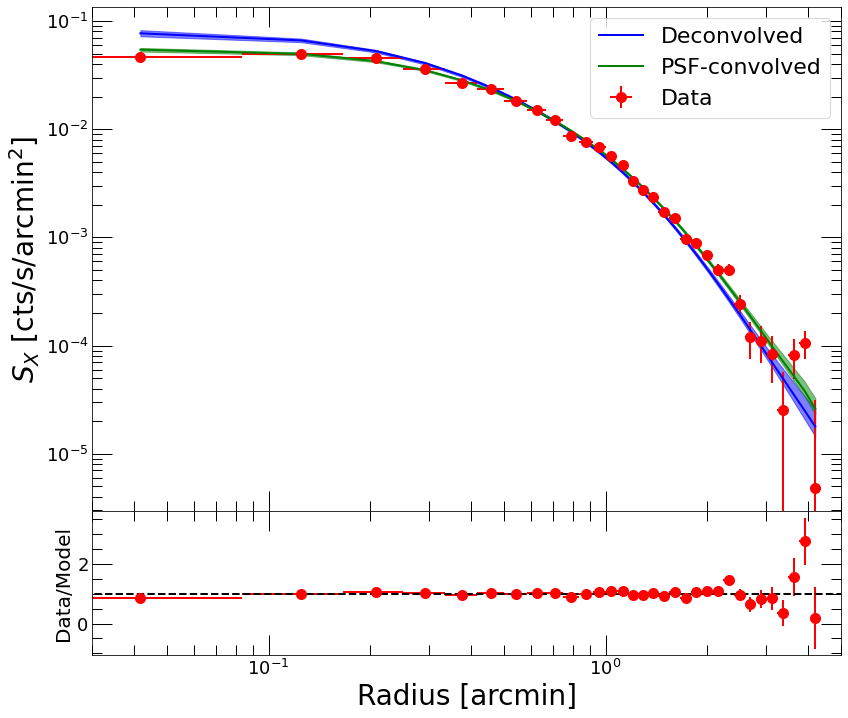

In [10]:
plt.clf()

fig = plt.figure()
ax=fig.add_axes([0.12,0.3,0.8,0.7])
ax_res=fig.add_axes([0.12,0.1,0.8,0.2])

ax.set_yscale('log')
ax.set_xscale('log')
ax_res.set_xscale('log')
ax_res.set_xlabel('Radius [arcmin]', fontsize=28)
ax_res.set_ylabel('Data/Model', fontsize=20)
ax.set_ylabel('$S_{X}$ [cts/s/arcmin$^2$]', fontsize=28)

ax.plot(p2.bins, mforw.sb_dec, color='blue', label='Deconvolved')
ax.fill_between(p2.bins, mforw.sb_dec_lo, mforw.sb_dec_hi, color='blue', alpha=0.5)
ax.errorbar(p2.bins, p2.profile, xerr=p2.ebins, yerr=p2.eprof, fmt='o', color='red', label='Data')


ax.plot(p2.bins, mforw.sb, color='green', label='PSF-convolved')
ax.fill_between(p2.bins, mforw.sb_lo, mforw.sb_hi, color='green', alpha=0.5)

ax.set_xlim(3e-2, 5.)

ax.legend(fontsize=22)

resid = p2.profile / mforw.sb
err_resid = p2.eprof / mforw.sb
ax_res.errorbar(p2.bins, resid, xerr=p2.ebins, yerr=err_resid, fmt='o', color='red')

ax_res.set_xlim(3e-2, 5.)

ax_res.plot(np.linspace(1e-2, 9., 100), np.ones(100), '--', color='black')



We can see that the model provides a good representation of the data at hand over the entire radial range. 

### Thermodynamic and mass profiles ###

We can now reconstruct the best-fit 3D thermodynamic profiles and their uncertainties. This is done using the [hydromass.prof_forw_hires](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.forward.prof_forw_hires) function, which computes the 3D pressure and gas density profiles at each step of the output chains. The median and 1-sigma percentiles are extracted for all the relevant derived quantities (temperature, entropy, cooling time). 


In [11]:
thermo_profiles = hydromass.prof_forw_hires(Mhyd=mforw,
                                            Forward=modforw,
                                            Z=0.3)

In [12]:
thermo_profiles.keys()

dict_keys(['R_IN', 'R_OUT', 'P_TOT', 'P_TOT_LO', 'P_TOT_HI', 'T3D', 'T3D_LO', 'T3D_HI', 'TSPEC', 'TSPEC_LO', 'TSPEC_HI', 'NE', 'NE_LO', 'NE_HI', 'K', 'K_LO', 'K_HI', 'T_COOL', 'T_COOL_LO', 'T_COOL_HI', 'LAMBDA', 'LAMBDA_LO', 'LAMBDA_HI'])

For instance, to check out that the 3D pressure profile ('P_TOT'), can proceed in the following way:

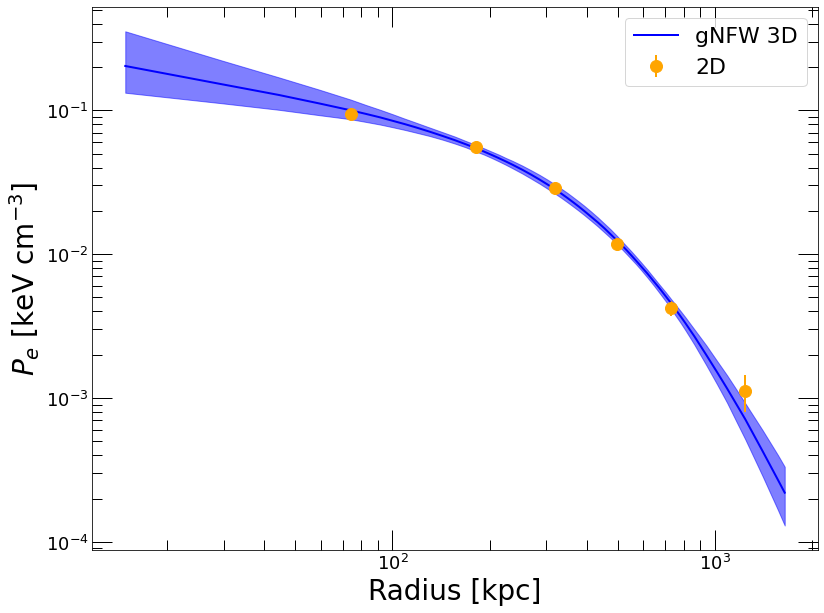

In [13]:
plt.clf()

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$P_{e}$ [keV cm$^{-3}$]', fontsize=28)

plt.plot(thermo_profiles['R_OUT'], thermo_profiles['P_TOT'], color='blue', label='gNFW 3D')
plt.fill_between(thermo_profiles['R_OUT'], thermo_profiles['P_TOT_LO'], thermo_profiles['P_TOT_HI'], color='blue', alpha=0.5)

pvals = np.interp(spec_data.rref_x, thermo_profiles['R_OUT'], thermo_profiles['NE']) * spec_data.temp_x
epvals = np.interp(spec_data.rref_x, thermo_profiles['R_OUT'], thermo_profiles['NE']) * spec_data.temph

plt.errorbar(spec_data.rref_x, pvals, yerr=epvals, fmt='o', color='orange', markersize=12, label='2D')

plt.legend(fontsize=22)


Here the orange points labelled "2D" refer to the gas density evaluated at the reference radii of the X-ray spectroscopic data and multiplied by the projected spectroscopic temperatures, which are known to be less affected by projection effects than the surface brightness. 

The above plot clearly shows that we have a good control over the pressure gradient, which allows us to compute the hydrostatic mass profile locally. The gradient of the gNFW profile is analytic (see [hydromass.der_lnP_np](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.forward.der_lnP_np)), thus it can be easily computed from the output parameter chains. This is done with the [hydromass.mass_forw_from_samples](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.forward.mass_forw_from_samples) function,

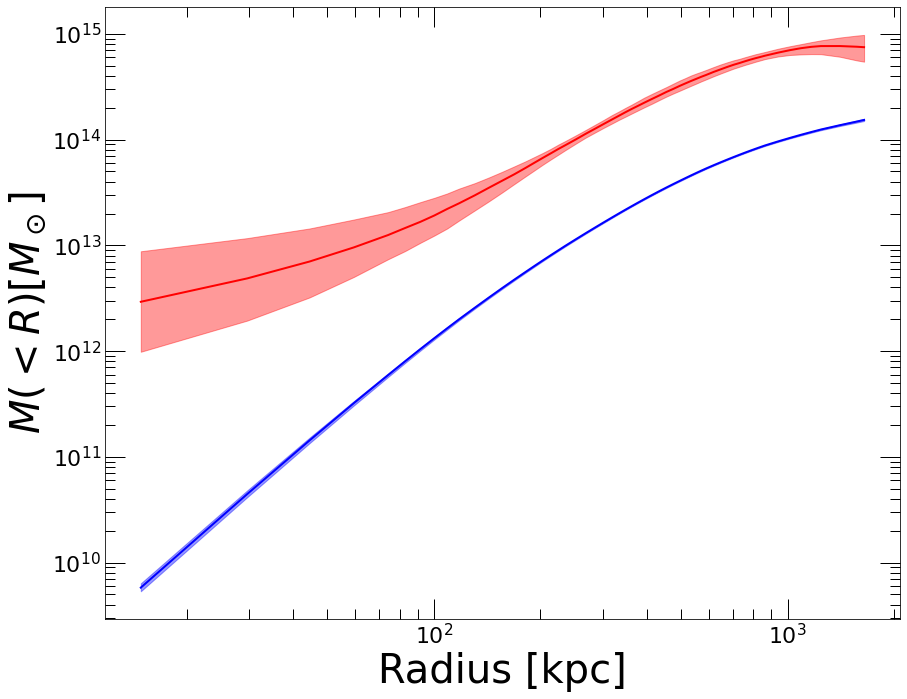

In [14]:
mass_forw, fig = hydromass.mass_forw_from_samples(Mhyd=mforw, 
                                                 Forward=modforw, 
                                                 plot=True)

Here the red curve and error envelope show the reconstructed hydrostatic mass profile, which is compared to the gas mass profile in blue.

In [15]:
mass_forw.keys()

dict_keys(['R_IN', 'R_OUT', 'MASS', 'MASS_LO', 'MASS_HI', 'MGAS', 'MGAS_LO', 'MGAS_HI', 'FGAS', 'FGAS_LO', 'FGAS_HI'])

Overdensity radii and masses can be computed for any user-defined overdensity in the following way,

<Figure size 936x720 with 0 Axes>

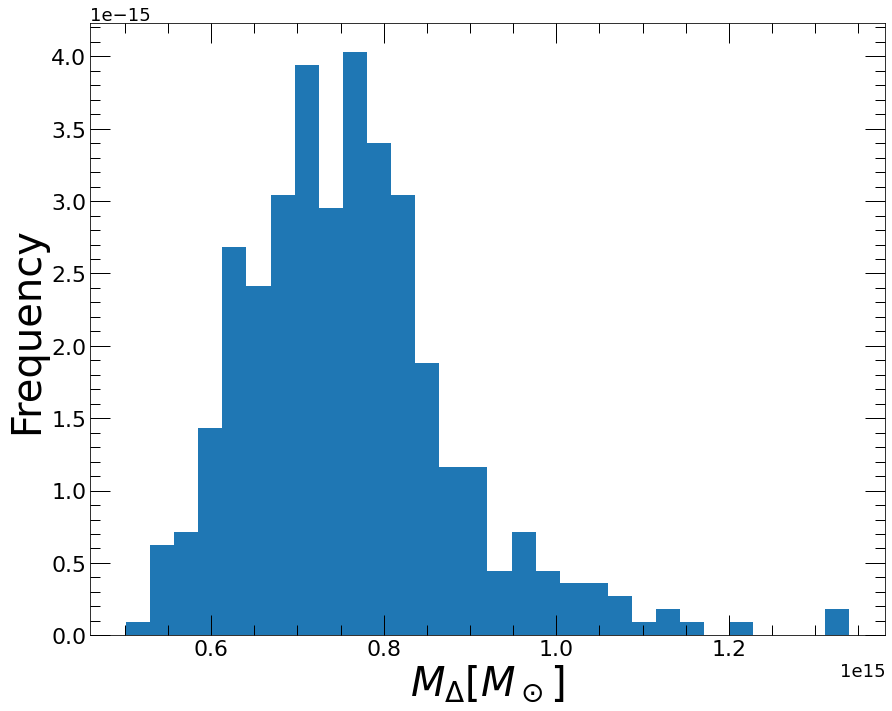

In [16]:
forw_r500, fig = hydromass.calc_rdelta_mdelta_forward(delta=500.,
                                                Mhyd=mforw, 
                                                Forward=modforw,
                                                rmin=300.,
                                                rmax=3000.,
                                                plot=True)

In [17]:
forw_r500['R_DELTA'] # R500 in kpc

1158.3840430197024

## Polytropic fit ##

Since the entropy in galaxy clusters is stratified, it is believed that the gas follows a polytropic relation, i.e. that there exists a simple relation between the gas density and pressure as

$$ P(r) = P_0 \left( \frac{n_e(r)}{n_0} \right)^\Gamma $$

with $\Gamma$ the _effective_ polytropic index. 

In the case of a fluid in hydrostatic equilibrium within a Navarro-Frenk-White potential well, the value of the polytropic index should be nearly universal and in the range 1.2-1.3 (e.g. [Capelo et al. 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.422..686C/abstract)). However, this prediction neglects the impact of cooling and non-gravitational entropy injection, which are substantial in cluster cores. In [Ghirardini et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...627A..19G/abstract) we showed that there exists a tight relation between pressure and density with small scatter (<15%). The polytropic index converges to the expected NFW value beyond $\sim0.2R_{500}$ but can decrease to $\sim0.8$ in cluster cores. 

Given its simplicity, the polytropic model is especially useful to reconstruct mass profiles from low-quality data, in which case the constraints on the surface brightness (and hence the density) are usually of much higher quality than the spectroscopic and/or SZ profiles.

### GammaR model ###

In _hydromass_ we implement the polytropic model including local variations of the polytropic index. Following [Ghirardini et al (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...627A..19G/abstract) we implement a radially dependent polytropic model ('GammaR', [hydromass.func_poly_rad_pm](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.polytropic.func_poly_rad_pm)) as

$$ \Gamma(R, n_e) = 1 + \Gamma_0 + \Gamma_R \frac{\partial \log R}{\partial \log n_e}\frac{1}{1+r/R_s} $$

Here we run a polytropic reconstruction with the "GammaR" model. The model can be called by setting up a [hydromass.Polytropic](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.polytropic.Polytropic) object, which works in a very similar way as a [hydromass.Forward](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.forward.Forward) object,


In [18]:
mpoly_rad = hydromass.Mhyd(sbprofile=p2, 
                        spec_data=spec_data, 
                        redshift=z_m0451)

modpoly_rad = hydromass.Polytropic(model='GammaR', redshift=z_m0451)

mpoly_rad.ccf = mforw.ccf

No output directory name provided, will output to subdirectory "mhyd" 
No cosmology provided, will default to Planck15
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc


In [19]:
mpoly_rad.run_polytropic(Polytropic=modpoly_rad, 
                         nmcmc=100, 
                         tune=100)

coefs -187.90419872441586
p0_interval__ -0.7913620439338243
Gamma0_interval__ -1.1264022130874443
GammaR_interval__ -1.3342208492851697
Rs_interval__ -1.1157504232392135
Running MCMC...


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 11000
Interrupted at 10,999 [5%]: Average Loss = 1.16e+13
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rs, GammaR, Gamma0, p0, coefs]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 23 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than

Done.
 Total computing time is:  0.5672562519709269  minutes


The resulting data can be viewed 

array([[<AxesSubplot:title={'center':'p0'}>,
        <AxesSubplot:title={'center':'p0'}>],
       [<AxesSubplot:title={'center':'Gamma0'}>,
        <AxesSubplot:title={'center':'Gamma0'}>],
       [<AxesSubplot:title={'center':'GammaR'}>,
        <AxesSubplot:title={'center':'GammaR'}>],
       [<AxesSubplot:title={'center':'Rs'}>,
        <AxesSubplot:title={'center':'Rs'}>]], dtype=object)

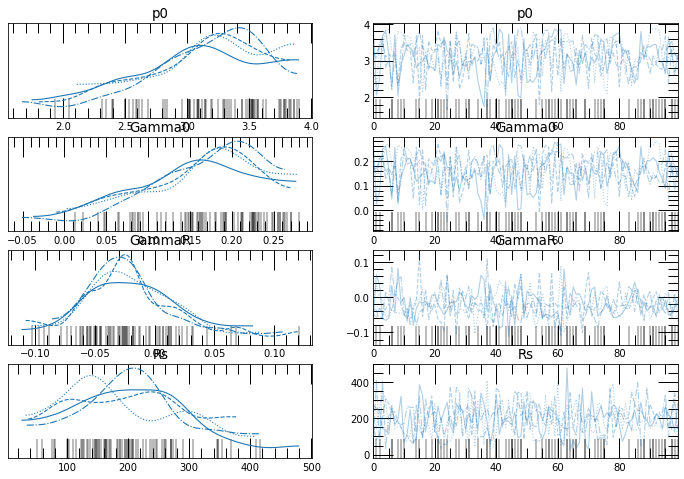

In [20]:
az.plot_trace(mpoly_rad.trace, var_names=['p0', 'Gamma0', 'GammaR', 'Rs'])

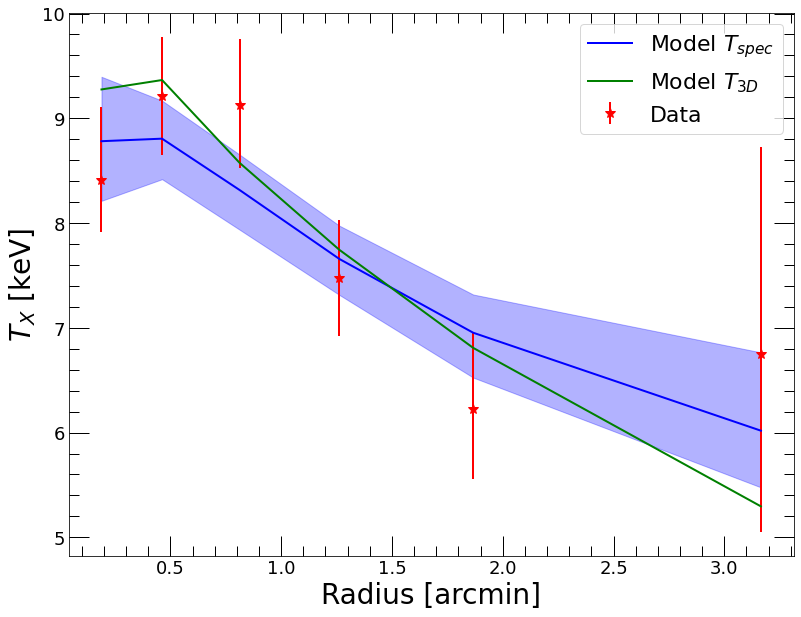

In [21]:
plt.clf()

plt.xlabel('Radius [arcmin]')
plt.ylabel('$T_{X}$ [keV]')

plt.errorbar(spec_data.rref_x_am,spec_data.temp_x,yerr=np.array([spec_data.templ,spec_data.temph]),fmt='*',color='red', label='Data')
plt.plot(spec_data.rref_x_am,mpoly_rad.ktmod,color='blue', label='Model $T_{spec}$')
plt.fill_between(spec_data.rref_x_am, mpoly_rad.ktmod_lo, mpoly_rad.ktmod_hi, color='blue', alpha=0.3)
plt.plot(spec_data.rref_x_am,mpoly_rad.kt3d,color='green', label='Model $T_{3D}$')

plt.legend(fontsize=22)

Again the model provides a nice representation of the data, but it includes several parameters cannot be easily computed a priori. Here $\Gamma_R$ fits to a value that is close to 0, implying that the polytropic index is almost constant at $1+\Gamma_0\approx 1.2$, in agreement with the prediction of the polytropic NFW model. 

### GammaN model ###

Alternatively, we also implement a density-dependent polytropic index model ('GammaN', [hydromass.func_poly_dens_pm](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.polytropic.func_poly_dens_pm)),

$$  \Gamma(n_e) = \Gamma_0 \left[ 1 + \Gamma_S \arctan\left( \frac{\log(n_e E(z)^{-2}/n_0)}{\Gamma_T} \right) \right]
 $$

The density-dependent fit can be used in exactly the same way by setting the 'GammaN' model instead of 'GammaR'. Here it is possible to fit only a single parameter (the normalization), which is the default implementation in _hydromass_. All the other parameters can be frozen, as the relation is known to be very universal, as shown in the plot below:

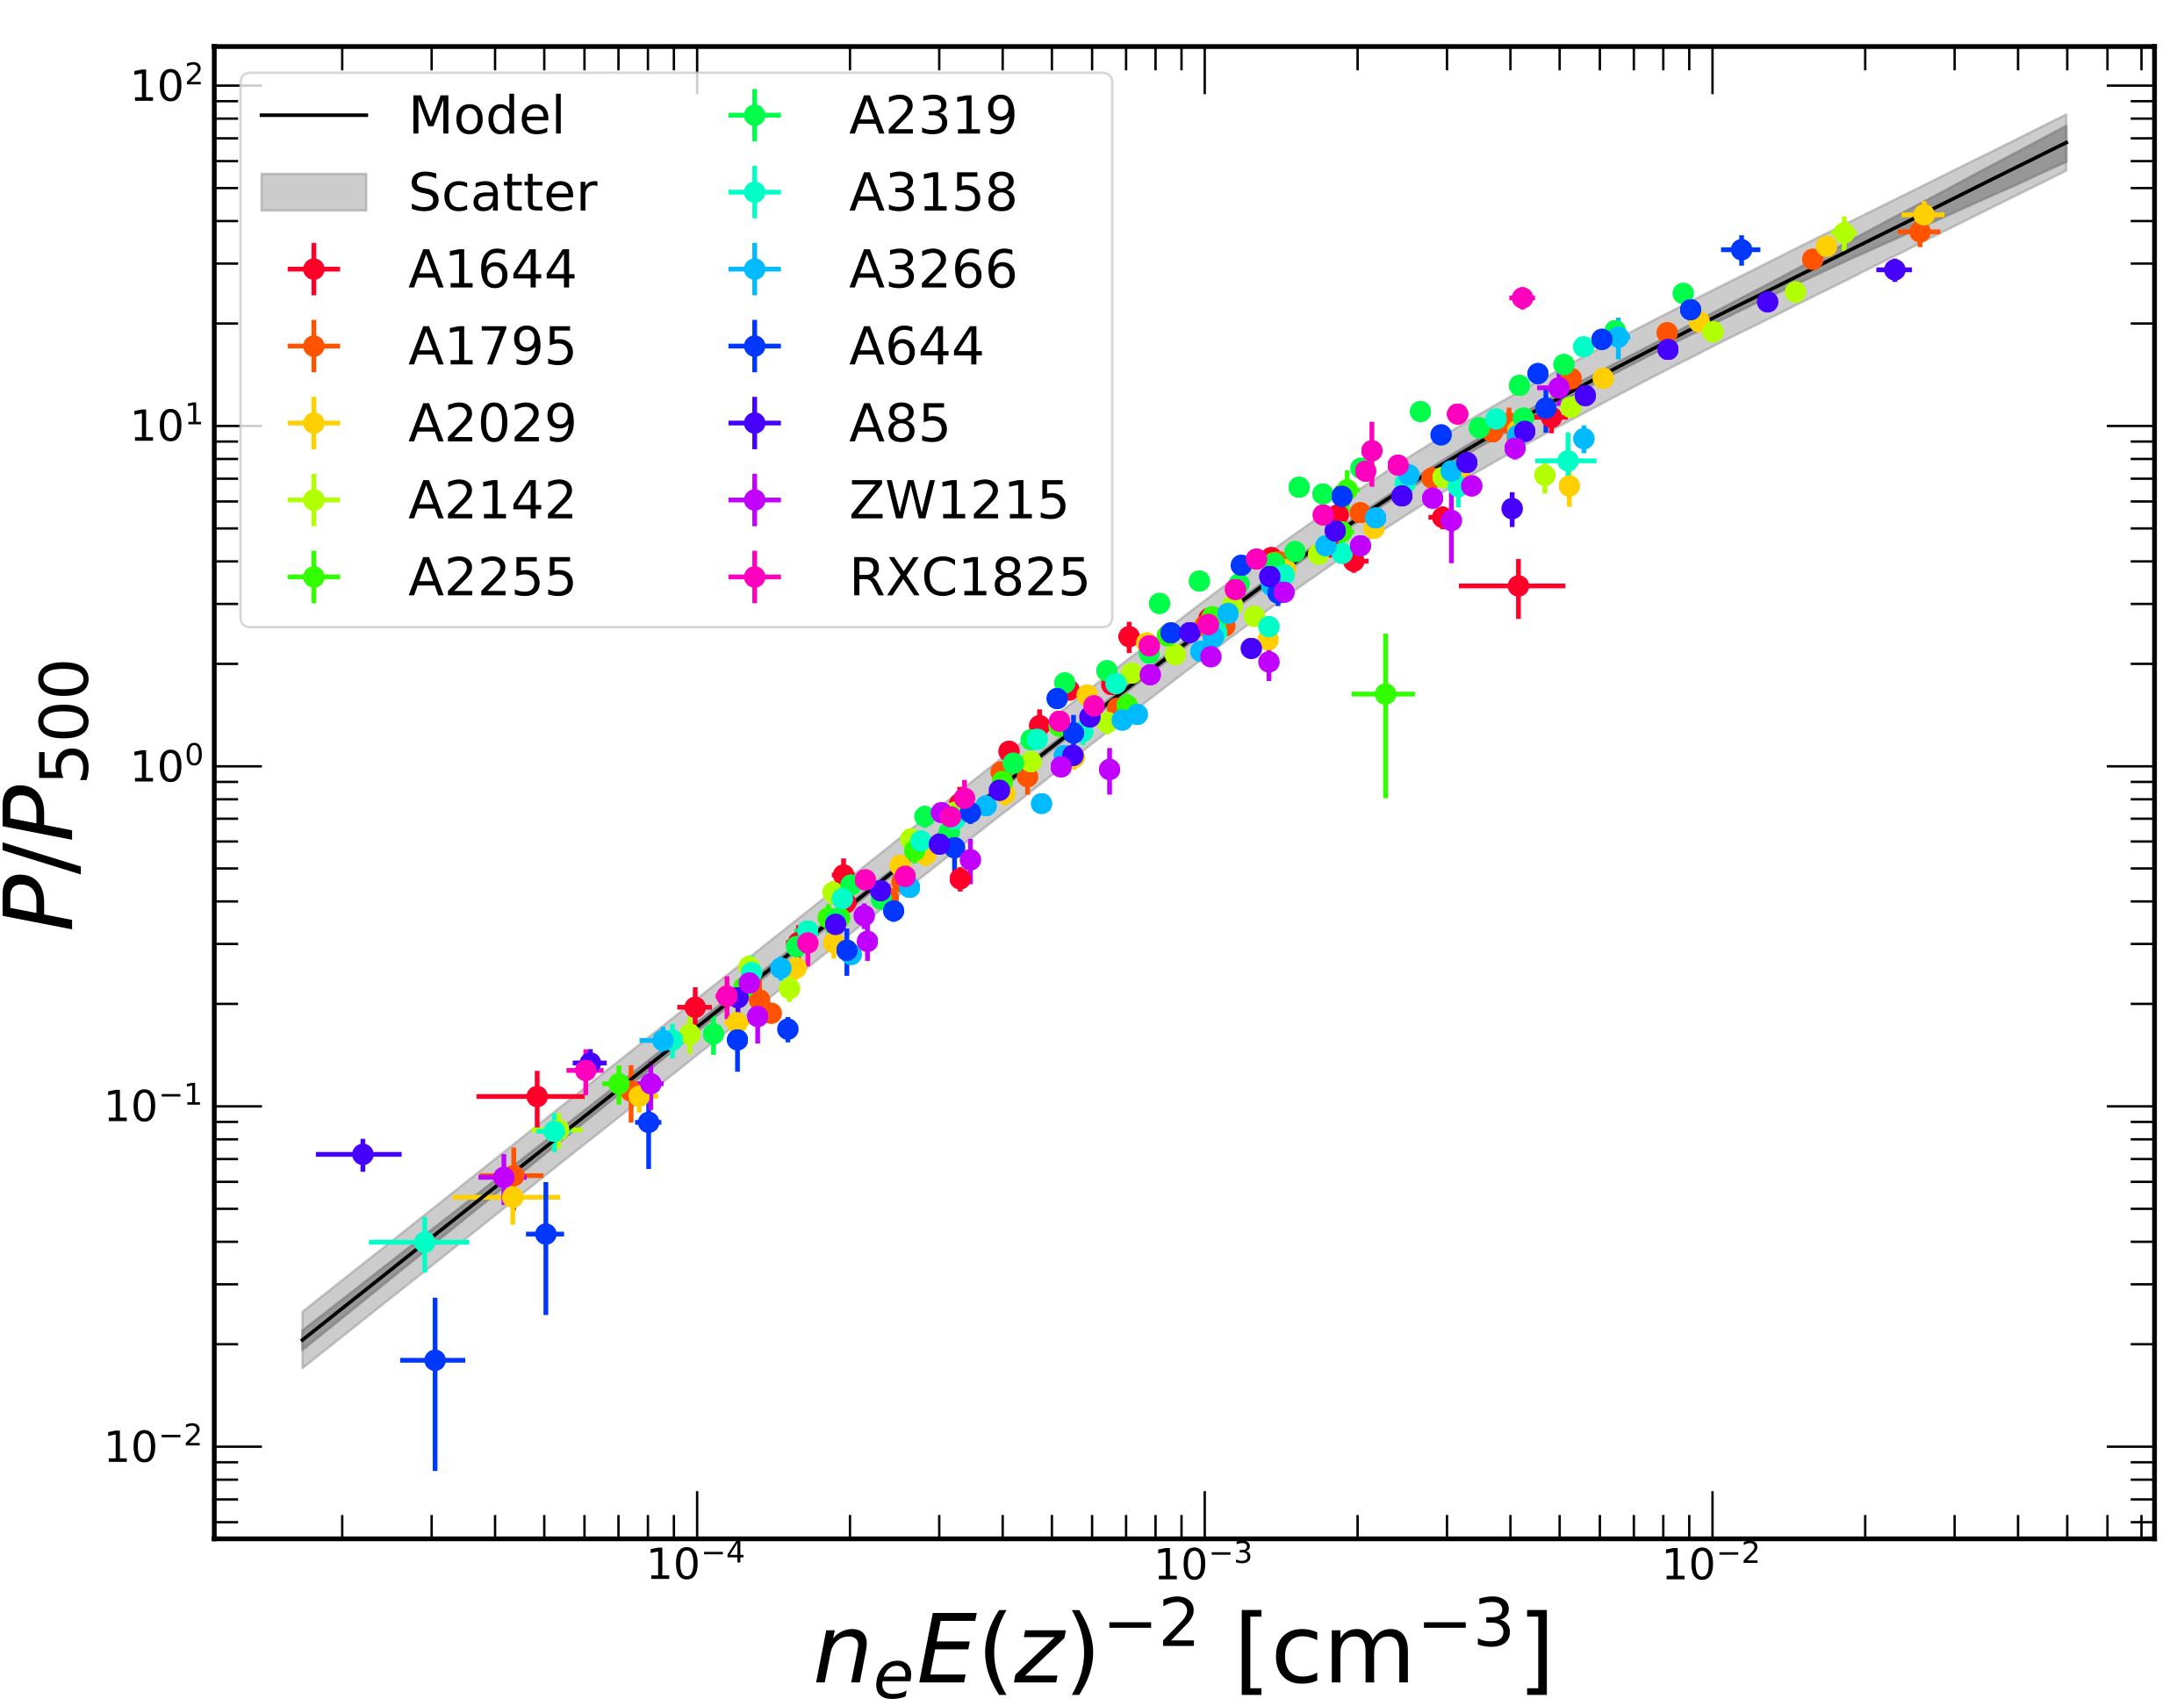

By default, only the $P0$ parameter is fitted. The other parameters of the model can obviously be released using the _fix_ attribute of the [hydromass.Polytropic](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.polytropic.Polytropic) class.

In [22]:
mpoly_dens = hydromass.Mhyd(sbprofile=p2, 
                        spec_data=spec_data, 
                        redshift=z_m0451, 
                        cosmo=pyproffit.cosmo)

modpoly_dens = hydromass.Polytropic(model='GammaN', redshift=z_m0451)

mpoly_dens.ccf = mforw.ccf


No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc


In [23]:
mpoly_dens.run_polytropic(Polytropic=modpoly_dens, 
                          nmcmc=100, 
                          tune=100)

coefs -187.90419872441586
p0_interval__ -1.0654103890534152
dummylogn0 -0.9189385332046727
dummytrans -0.9189385332046727
dummyGamma0 -0.9189385332046727
dummyscale -0.9189385332046727
Running MCMC...


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 24500
Interrupted at 24,499 [12%]: Average Loss = 282.03
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummyscale, dummyGamma0, dummytrans, dummylogn0, p0, coefs]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 24 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


Done.
 Total computing time is:  0.5369397004445394  minutes


array([[<AxesSubplot:title={'center':'p0'}>,
        <AxesSubplot:title={'center':'p0'}>]], dtype=object)

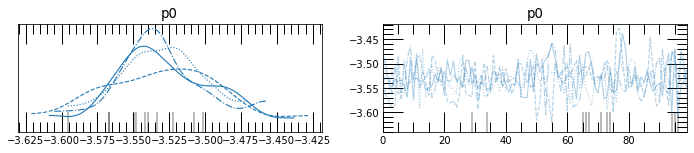

In [24]:
az.plot_trace(mpoly_dens.trace, var_names=['p0'])

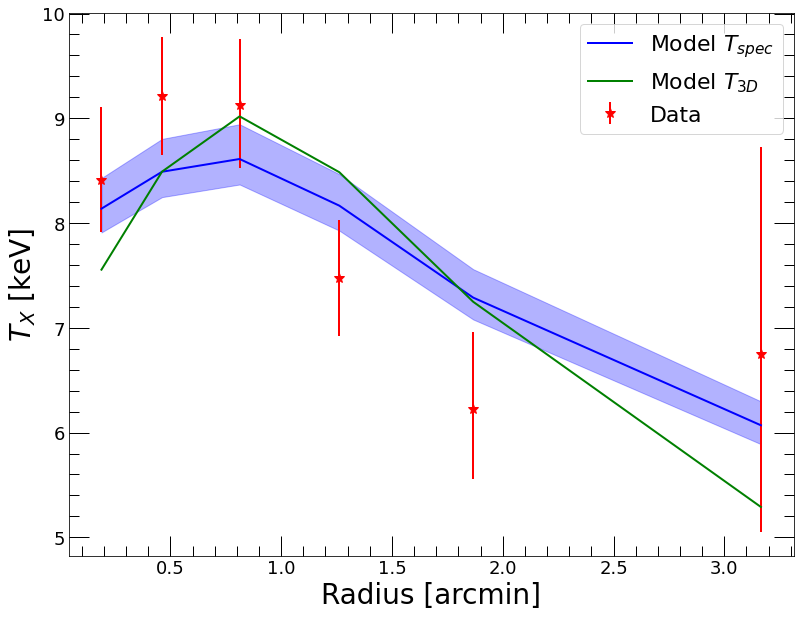

In [25]:
plt.clf()

plt.xlabel('Radius [arcmin]')
plt.ylabel('$T_{X}$ [keV]')

plt.errorbar(spec_data.rref_x_am,spec_data.temp_x,yerr=np.array([spec_data.templ,spec_data.temph]),fmt='*',color='red', label='Data')
plt.plot(spec_data.rref_x_am,mpoly_dens.ktmod,color='blue', label='Model $T_{spec}$')
plt.fill_between(spec_data.rref_x_am, mpoly_dens.ktmod_lo, mpoly_dens.ktmod_hi, color='blue', alpha=0.3)
plt.plot(spec_data.rref_x_am,mpoly_dens.kt3d,color='green', label='Model $T_{3D}$')

plt.legend(fontsize=22)


We can see that the model provides a reasonable description of the temperature profile, even though the pressure model only has a single parameter ($P_0$). The shape of the temperature profile is set entirely by the local values of the gas density and the $\Gamma(n_e)$ model.


## Comparing the mass models ##

The hydrostatic mass profiles from the polytropic fits can be easily derived from the output chains by computing the pressure gradient analytically. This is achieved through the [hydromass.mass_poly_from_samples](https://hydromass.readthedocs.io/en/latest/hydromass.html#hydromass.polytropic.mass_poly_from_samples) function.

Let's now compare the mass models obtained with the three different parametric models (gNFW, GammaR, and GammaN). 


In [26]:
mass_poly_dens = hydromass.mass_poly_from_samples(Mhyd=mpoly_dens, 
                                                  Polytropic=modpoly_dens)


We can also reload the fitted NFW model ([see this tutorial](https://hydromass.readthedocs.io/en/latest/Mass_model.html)) and compare it with the parametric fits.  

In [27]:
m_nfw = hydromass.Mhyd(sbprofile=p2, 
                       spec_data=spec_data,
                       redshift=z_m0451)

mod_nfw = hydromass.ReloadModel(Mhyd=m_nfw, infile='mhyd/test_save.fits')

mass_nfw = hydromass.mass_from_samples(Mhyd=m_nfw, model=mod_nfw)

No output directory name provided, will output to subdirectory "mhyd" 
No cosmology provided, will default to Planck15
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc


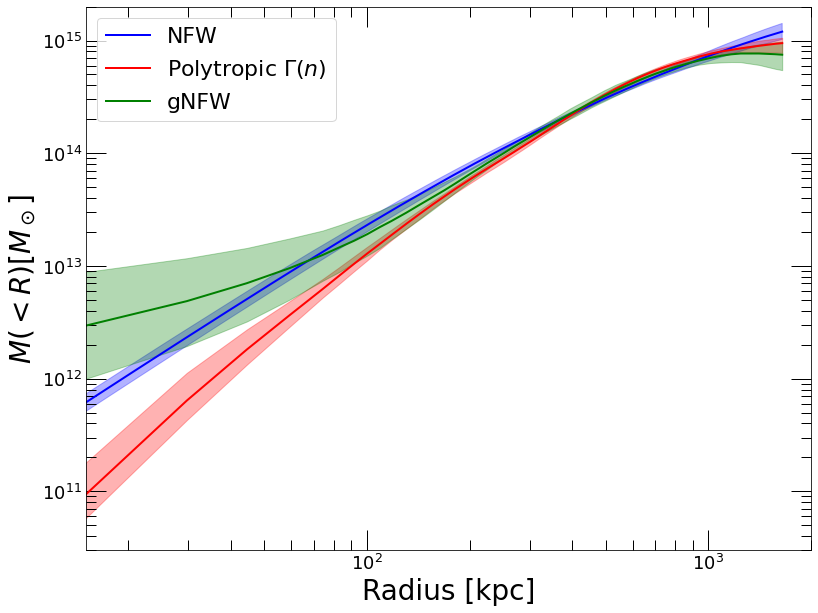

In [28]:
plt.clf()

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]')
plt.ylabel('$M(<R) [M_\odot]$')

plt.plot(mass_nfw['R_OUT'], mass_nfw['MASS'],color='blue', label='NFW')
plt.fill_between(mass_nfw['R_OUT'], mass_nfw['MASS_LO'], mass_nfw['MASS_HI'], color='blue', alpha=0.3)

plt.plot(mass_poly_dens['R_OUT'], mass_poly_dens['MASS'],color='red', label='Polytropic $\Gamma(n)$')
plt.fill_between(mass_poly_dens['R_OUT'], mass_poly_dens['MASS_LO'], mass_poly_dens['MASS_HI'], color='red', alpha=0.3)

plt.plot(mass_forw['R_OUT'], mass_forw['MASS'],color='green', label='gNFW')
plt.fill_between(mass_forw['R_OUT'], mass_forw['MASS_LO'], mass_forw['MASS_HI'], color='green', alpha=0.3)

plt.axis([15., 2000., 3e10, 2e15])

plt.legend(fontsize=22)


All the models provide consistent results in the range between 100 kpc and 1 Mpc, where the data are most constraining. Differences especially in the innermost 100 kpc can be observed. In the gNFW case, the shape of the pressure profile in the core follows a power law with slope $\gamma$, which often tends to overestimate the pressure gradient in the core. Conversely, the NFW model imposes a fixed mass density slope of -1 in the core. Finally, the shape of the polytropic model is set by the local gas density.

We can also compare the resulting $f_{gas}$ profiles,

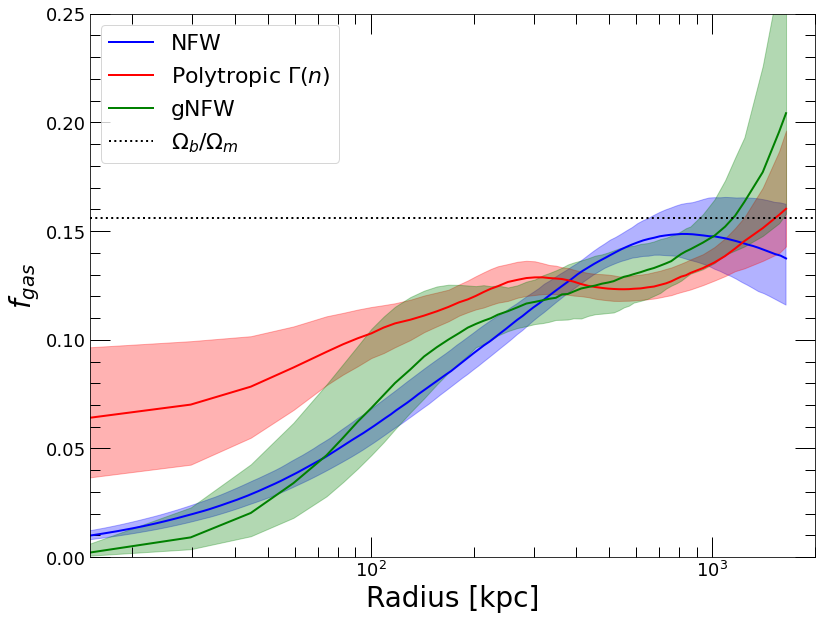

In [29]:
plt.clf()

plt.xscale('log')
plt.xlabel('Radius [kpc]')
plt.ylabel('$f_{gas}$')

plt.plot(mass_nfw['R_OUT'], mass_nfw['FGAS'],color='blue', label='NFW')
plt.fill_between(mass_nfw['R_OUT'], mass_nfw['FGAS_LO'], mass_nfw['FGAS_HI'], color='blue', alpha=0.3)

plt.plot(mass_poly_dens['R_OUT'], mass_poly_dens['FGAS'],color='red', label='Polytropic $\Gamma(n)$')
plt.fill_between(mass_poly_dens['R_OUT'], mass_poly_dens['FGAS_LO'], mass_poly_dens['FGAS_HI'], color='red', alpha=0.3)

plt.plot(mass_forw['R_OUT'], mass_forw['FGAS'],color='green', label='gNFW')
plt.fill_between(mass_forw['R_OUT'], mass_forw['FGAS_LO'], mass_forw['FGAS_HI'], color='green', alpha=0.3)

rv = np.linspace(15., 2000., 100)
plt.plot(rv, np.ones(100)*0.156, ':', color='black', label='$\Omega_b/\Omega_m$')

plt.axis([15., 2000., 0., 0.25])

plt.legend(fontsize=22)


Here again all the methods provide consistent results beyond 100 kpc and diverge in the core, for the same reason as the differences in the mass profiles described above.